<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20241227%5D%20FL-DL%20MLP-LSTM%20model%2010%20classes%20with%20early%20stopped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [59]:
# Load dataset
dataset = pd.read_csv("Dataset_10Classes.csv") #UNSW-NB15 10 classes dataset

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [60]:
dataset

,ID_Cb,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,Class
0,1,1,0.121478,tcp,-,FIN,6,4,258,172,...,1,0,0,0,1,1,0,Normal,0,0
1,2,2,0.649902,tcp,-,FIN,14,38,734,42014,...,2,0,0,0,1,6,0,Normal,0,0
2,3,3,1.623129,tcp,-,FIN,8,16,364,13186,...,3,0,0,0,2,6,0,Normal,0,0
3,4,4,1.681642,tcp,ftp,FIN,12,12,628,770,...,3,1,1,0,2,1,0,Normal,0,0
4,5,5,0.449454,tcp,-,FIN,10,6,534,268,...,40,0,0,0,2,39,0,Normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,257669,82328,0.000005,udp,-,INT,2,0,104,0,...,2,0,0,0,2,1,0,Normal,0,0
257669,257670,82329,1.106101,tcp,-,FIN,20,8,18062,354,...,1,0,0,0,3,2,0,Normal,0,0
257670,257671,82330,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0
257671,257672,82331,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0


**Data Preprocessing**

In [61]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [62]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [93000  2677  2329 16353 44525 24246 58871 13987  1511   174]


In [63]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [64]:
!pip install -U imbalanced-learn

In [65]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [93000 93000 93000 93000 93000 93000 93000 93000 93000 93000]


In [66]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

In [67]:
from keras.regularizers import l2

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the hybrid MLP + LSTM model with regularization and other techniques to reduce overfitting
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # MLP layers with L2 regularization
    model.add(Dense(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Increased dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))

    # Dense layers for final feature extraction
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], )
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23250/23250 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.8691 - loss: 0.7601 - val_accuracy: 0.9967 - val_loss: 0.2273
Epoch 2/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.9691 - loss: 0.3109 - val_accuracy: 0.9964 - val_loss: 0.2016
Epoch 3/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step - accuracy: 0.9725 - loss: 0.2784 - val_accuracy: 0.9965 - val_loss: 0.1939
Epoch 4/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.9733 - loss: 0.2636 - val_accuracy: 0.9947 - val_loss: 0.1767
Epoch 5/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.9742 - loss: 0.2565 - val_accuracy: 0.9986 - val_loss: 0.1700
Epoch 6/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.9742 - loss: 0.2495 - val_accuracy: 0.9978 - val_loss: 0.1714
Epoch 7/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9755 - loss: 0.2440 - val_accuracy: 0.9965 - val_loss: 0.1715
Epoch 8/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step - accuracy: 0.97

In [68]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.9983118280
Precision: 0.9983140778
Recall: 0.9983118280
F1-Score: 0.9983111680


In [69]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

5813/5813 ━━━━━━━━━━━━━━━━━━━━ 4s 714us/step
Accuracy: 0.9983118280
Precision: 0.9983140778
Recall: 0.9983118280
F1-Score: 0.9983111680


In [70]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[18595     0     0     0     0     0     0     0     0     5]
 [    0 18600     0     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    0     1     0 18588    11     0     0     0     0     0]
 [    0     4     0    78 18506    12     0     0     0     0]
 [    2     0     0     0     4 18552    42     0     0     0]
 [    0     0     0     6     2    88 18461    43     0     0]
 [    0     0     0     4     0     0     0 18584    12     0]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]


In [71]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.99973118 1.         1.         0.99935484 0.99494624 0.99741935
 0.99252688 0.99913978 1.         1.        ]


In [72]:
# Import roc_auc_score along with other metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# AUC and ROC Curve
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print("AUC: {:.10f}".format(auc))

AUC: 0.9999589274


AUC: 0.9999589274


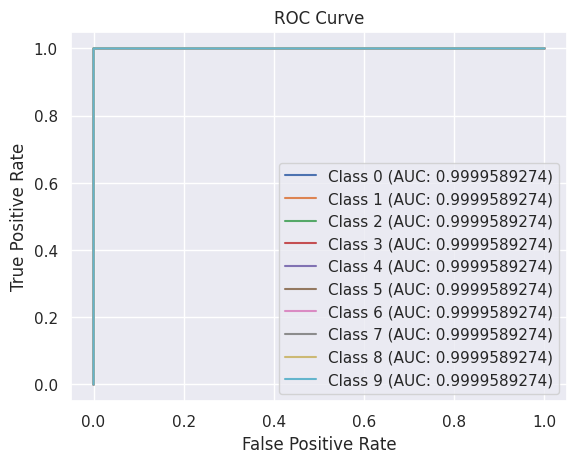

In [88]:
# Import roc_auc_score along with other metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Import roc_curve
from sklearn.metrics import roc_curve # Add this line to import roc_curve
import matplotlib.pyplot as plt # Import matplotlib
import seaborn as sns  # Import seaborn and assign it to the alias 'sns'

# AUC and ROC Curve
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print("AUC: {:.10f}".format(auc))
# Plot ROC curve for each class
fpr = {}
tpr = {}
thresh = {}
for i in range(num_classes):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test[:, i], y_pred[:, i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC: {:.10f})'.format(i, auc))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

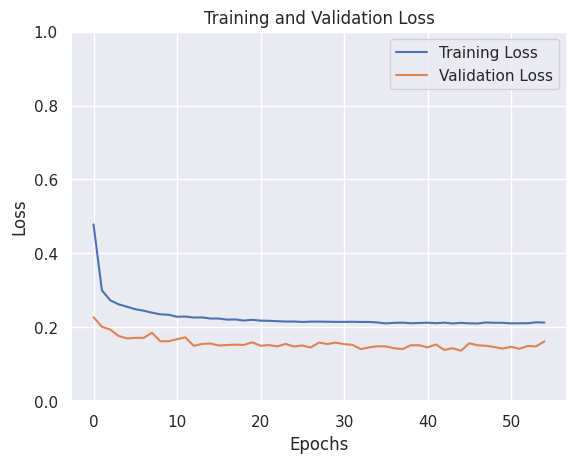

In [87]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  ax.yaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


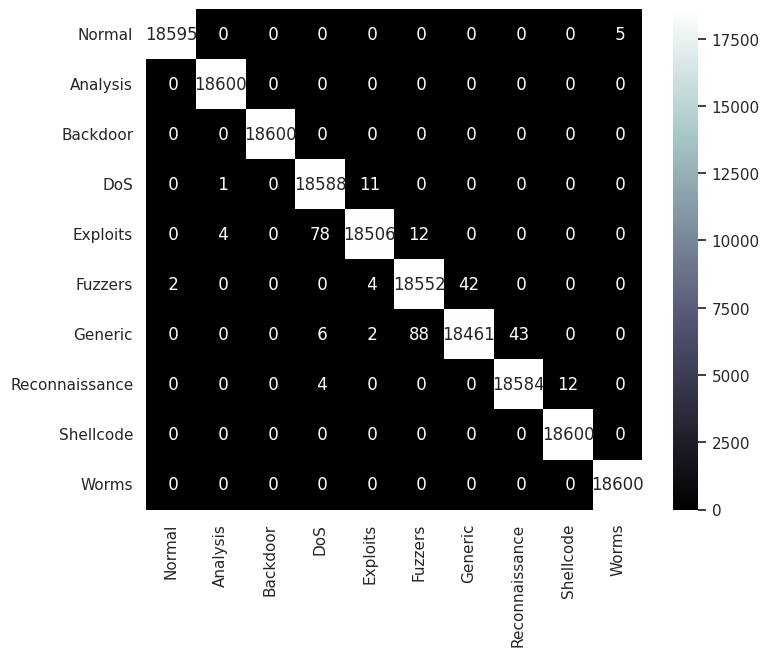

In [85]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(10), labels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'], rotation=45)
plt.yticks(ticks=np.arange(10), labels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'], yticklabels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
sns.set(font_scale=1)
plt.show() # Display the heatmap

In [97]:
def conf_mat(d1,d2):
  cm = confusion_matrix(y_true_classes, y_pred_classes)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="gist_yarg",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  ax.yaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Federated DL// MLP-LSTM Model


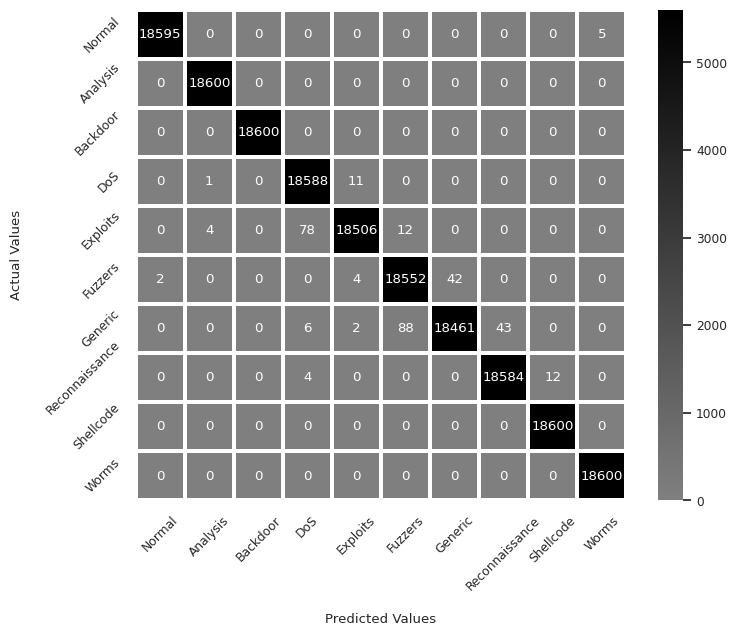

In [98]:
print("Confusion Matrix of Federated DL// MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)